In [1]:
import torch
import os
import sys
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from model_parametrized.pinnsformer import PINNsformer
from pde_dataset import PDEData
from config import HyperparamConfig

In [2]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cpu'

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: False


### Configure initial dataset and hyperparameters

In [69]:
config = HyperparamConfig(
    total_i=10,
    dataset="1d-reaction-pde",
    model_name="pinnsformer",  # Model name
    in_dim=3,
    hidden_dim=512,
    out_dim=1,
    emb_dim=32,
    num_layer=1,
    num_heads=2,
    init_weights="xavier uniform",
    bias_fill=0.01,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=128
)

# Validate the configuration
config.validate()

print("Configuration:")
print(config.to_dict())

Configuration:
{'total_i': 10, 'dataset': '1d-reaction-pde', 'model_name': 'pinnsformer', 'in_dim': 3, 'hidden_dim': 512, 'out_dim': 1, 'num_layer': 1, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'emb_dim': 32, 'num_heads': 2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}


### 1. Hyperparameter Tuning: Small $\rho$ parameter variance datasets, adam optimizer with mini batching

In [70]:
def compute_relative_errors(model, dataset, rho, device):
    
    # Get test points for the current rho
    res_test, x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)  # Create rho tensor for test points

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    return rl1, rl2

In [71]:
import torch
import wandb
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [72]:
# === Helper Function for One Training Run ===
def run_training(config_dict, model, optim, dataset, rho_values, device):
    """
    Perform one training run based on the provided configuration.

    Args:
        config_dict (dict): Configuration dictionary containing hyperparameters.
        model (torch.nn.Module): The model to train.
        dataset: Dataset object providing interior and initial condition points.
        rho_values (list): List of rho values for training.
        device (torch.device): Device to run the training on (e.g., 'cuda' or 'cpu').
    """
    wandb.init(
        project="gnn_1d_reaction",
        config=config_dict,
        settings=wandb.Settings(silent=True),
        mode="offline"
    )

    momentum_dict = {}  # Reset for each run
    loss_track = {}
    model.train() # set to training mode

    for i in tqdm(range(config_dict["total_i"])):
        total_loss_res = 0.0
        total_loss_bc = 0.0
        total_loss_ic = 0.0
        num_batches = 0  # Track the number of batches

        for rho in rho_values:
            # Get interior points and create a mini-batch DataLoader
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            interior_dataset = TensorDataset(x_res, t_res, rho_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            # Get full boundary data for current rho
            (x_left, t_left, rho_left,
            x_right, t_right, rho_right,
            x_upper, t_upper, rho_upper,
            x_lower, t_lower, rho_lower) = dataset.get_boundary_points(rho)
            u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

            for bx, bt, brho in interior_loader:
                bx.requires_grad_()
                bt.requires_grad_()

                pred_res = model(bx.to(device), bt.to(device), brho.to(device))
                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                          retain_graph=True, create_graph=True)[0]

                if config_dict["normalize_res"]:
                    normalized_res_error = (u_t - brho * pred_res * (1 - pred_res)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_res = torch.mean(normalized_res_error ** 2)
                else:
                    loss_res = torch.mean((u_t - brho * pred_res * (1 - pred_res)) ** 2)

                pred_ic = model(x_lower.to(device), t_lower.to(device), rho_lower.to(device))

                if config_dict["normalize_ic"]:
                    normalized_ic_error = (pred_ic - u_lower.to(device)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_ic = torch.mean(normalized_ic_error ** 2)
                else:
                    loss_ic = torch.mean((pred_ic - u_lower.to(device)) ** 2)

                if config_dict["adaptive_loss_weighting"]:
                    grad_res = compute_grad_norm(loss_res, model)
                    grad_ic = compute_grad_norm(loss_ic, model)

                    grads = {'res': grad_res, 'ic': grad_ic}
                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["adaptive_loss_coeff"])
                    gamma = compute_loss_weights(momentum_dict)

                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic
                else:
                    loss = loss_res + loss_ic

                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

                total_loss_res += loss_res.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1

        avg_loss_res = total_loss_res / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_ic

        wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        }

        total_l1 = 0.0
        total_l2 = 0.0
        for rho in rho_values:
            rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
            wandb_dict[f"{rho}_rl1"] = rl1
            wandb_dict[f"{rho}_rl2"] = rl2
            total_l1 += rl1 
            total_l2 += rl2

        average_l1 = total_l1 / len(rho_values) 
        average_l2 = total_l2 / len(rho_values)

        wandb.log(wandb_dict)
        loss_track[i] = wandb_dict

    wandb.finish()
    return loss_track, average_l1, average_l2


In [73]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [74]:
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

In [81]:
# Define rho values
rho_values =[0.5] #[0.5, 0.7, 0.8, 1.0] # small range

""" start = 0.5 
end = 4.0
rho_values = generate_rho_values(start, end, num=5) """


# Create the dataset using the ODEData class.
# Note: We now provide t_range, t_points, a constant x value (e.g., 1.0), and rho_values.
dataset = PDEData(x_range=[0, 2*np.pi],t_range=[0, 1], rho_values=rho_values,x_points=101 ,t_points=101)

device="cpu"
# === Variations ===
normalize_res_values = [False] #[True, False]
normalize_ic_values = [False] #[True, False]
adaptive_loss = [True, False]
adaptive_loss_weighting_coeffs = [0.7, 0.9]
alpha_values = [None]#[0.1, 0.25] #[0.1, 0.25, 0.5]
epsilon_values = [None]#[0.1, 0.3] #[0.1, 0.5, 1.0]
iteration_steps = [20] #[50, 100, 400]
models = []

""" 
for init_act,subseq_act in [("sin", "tanh"), ("sin","gelu"), ("tanh", "gelu")]:
    model = PINNff(in_dim=config.in_dim, 
                   hidden_dim=config.hidden_dim,
                   out_dim=config.out_dim,
                   num_layer=config.num_layer,
                   init_act_func=init_act,
                   subseq_activ_func=subseq_act).to(device)
    model.apply(init_weights)
    models.append((model,init_act, subseq_act)) """

model_variations = [
    #(32,1,128),
    #(32,2,256),
    (32,2,512),
    #(64,3,512)
]
for emb_dim,num_heads,hidden_dim in model_variations:
    model = PINNsformer(
            d_out=config.out_dim,
            d_model=emb_dim,
            d_hidden=hidden_dim,
            N=config.num_layer,
            heads=num_heads).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim))


# === Grid Search ===
best_model = None
best_config = None
best_l1 = float('inf')
best_l2 = float('inf')

for model,emb_dim,num_heads,hidden_dim in models: 
    for normalize_res in normalize_res_values:
        for normalize_ic in normalize_ic_values:
            for ad_loss in adaptive_loss:
                for a_coeff in adaptive_loss_weighting_coeffs:
                    if ad_loss == False:
                        continue
                    for alpha in alpha_values:
                        for epsilon in epsilon_values:
                            for total_i in iteration_steps:
                                config.normalize_res = normalize_res
                                config.normalize_ic = normalize_ic
                                config.adaptive_loss_coeff = a_coeff
                                config.alpha = alpha
                                config.epsilon = epsilon
                                config.total_i = total_i
                                config.adaptive_loss_weighting = ad_loss
                                config.hidden_dim = hidden_dim 
                                config.emb_dim = emb_dim
                                config.num_heads = num_heads
                                config.validate()

                                # Call the training function
                                config_dict = config.to_dict()
                                if config.optimizer == "adam":
                                    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                                loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, rho_values, device)

                                # Update the best model if the current one is better
                                if avg_l1 < best_l1 and avg_l2 < best_l2:
                                    best_model = model
                                    best_config = config_dict.copy()
                                    best_l1 = avg_l1
                                    best_l2 = avg_l2

# Print the best model and configuration
print("Best Model Configuration:")
print(best_config)
print(f"Best Average L1 Error: {best_l1}")
print(f"Best Average L2 Error: {best_l2}")

100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


Best Model Configuration:
{'total_i': 20, 'dataset': '1d-reaction-pde', 'model_name': 'pinnsformer', 'in_dim': 3, 'hidden_dim': 512, 'out_dim': 1, 'num_layer': 1, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'emb_dim': 32, 'num_heads': 2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.7}
Best Average L1 Error: 1.179150938987732
Best Average L2 Error: 1.065219521522522


In [82]:
# %%
from pathlib import Path

base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [83]:
def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple rho values in a grid layout.

    Args:
        rho_values (list): List of rho values.
        predictions (dict): Dictionary of predictions for each rho value.
        analytical_solutions (dict): Dictionary of analytical solutions for each rho value.
        errors (dict): Dictionary of absolute errors for each rho value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_rho = len(rho_values)
    num_rows = 2  # Fixed: Row 1 for predictions, Row 2 for errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        # Extract data for the current rho
        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        #ax_pred.plot(analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
        ax_pred.set_title(f"Rho: {rho} - Prediction")
        ax_pred.set_xlabel("x")  # Horizontal axis label
        ax_pred.set_ylabel("t")  # Vertical axis label
        #ax_pred.colorbar()
        

        # Plot absolute and percentage errors (Row 2)
        #ax_err = axes[1, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        #ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        #ax_err.set_title(f"Rho: {rho} - Relative Error (%)")
        #ax_err.set_xlabel("t - Time")  # Horizontal axis label
        #ax_err.set_ylabel("delta u(t) (%)")  # Vertical axis label
        #ax_err.legend()

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

In [84]:
def test_on_parameter_range(rho_values, dataset, model):
    predictions = {}
    analytical_solutions = {}
    errors = {}

    for rho in rho_values:
        # Get test points for the current rho
        res_test, x_test, t_test, _ = dataset.get_test_points(rho)
        rho_test = torch.full_like(x_test, rho).to(device)

        # Compute analytical solution
        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101,101)

        # Compute best model predictions
        with torch.no_grad():
            pred = best_model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
            pred = pred.cpu().detach().numpy().reshape(101,101)

        # Compute error
        error = np.abs(u_analytical - pred)

        # Store results
        predictions[rho] = pred
        analytical_solutions[rho] = u_analytical
        errors[rho] = error

    return predictions, analytical_solutions, errors

Figure saved to images/predictions_and_errors_1d_reaction.png


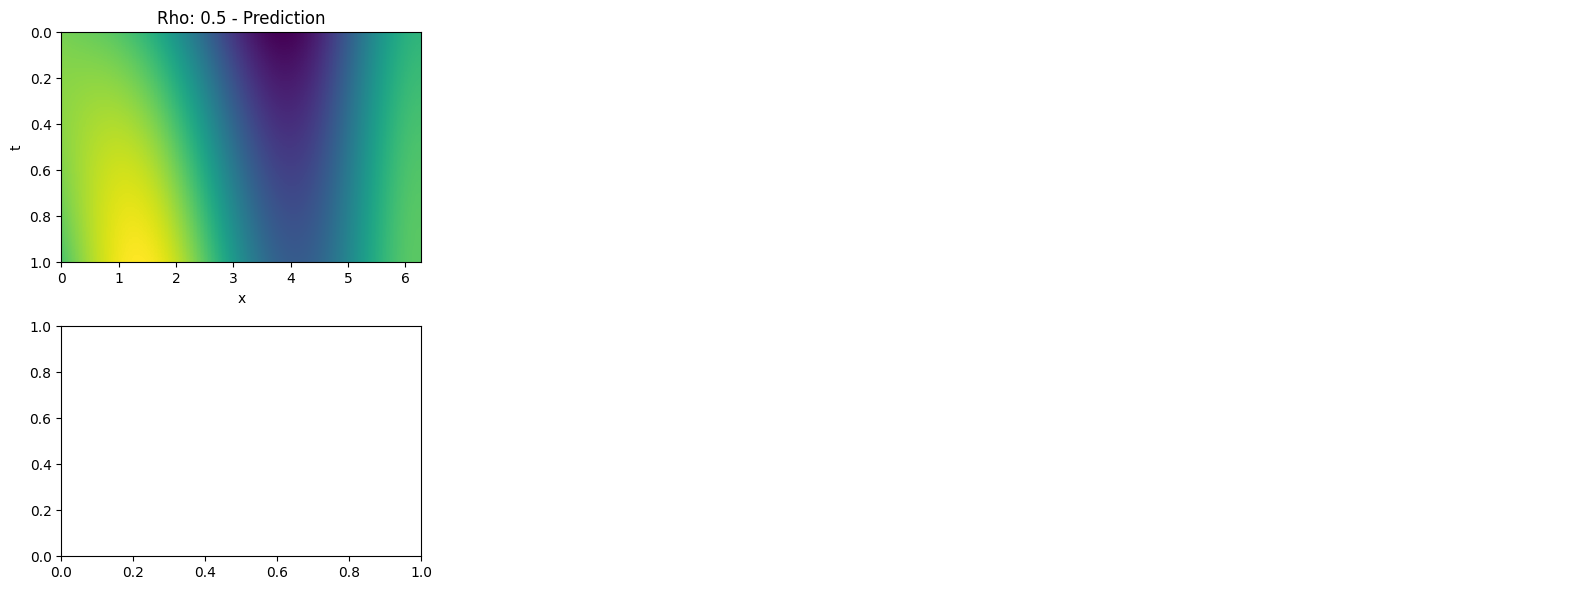

In [85]:
best_model.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=4,
    save_path=images_dir / "predictions_and_errors_1d_reaction.png"
)

### Testing best model on different rho ranges


**Best model configuration:**

{'total_i': 400, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'gelu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.9}


In [38]:
load_existing_model = False

if load_existing_model == True:
    best_model = PINNff(
        in_dim=3,  # Input dimension (e.g., x, t, rho)
        hidden_dim=256,  # Hidden layer size (must match the saved model)
        out_dim=1,  # Output dimension
        num_layer=4,  # Number of layers
        init_act_func="tanh",  # Initial activation function
        subseq_activ_func="gelu"  # Subsequent activation function
    ).to(device)

    # Load the model weights
    model_path = weights_dir / "1d_logistic_ode_fls_extended.pt"  # Path to the saved model
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()  # Set the model to evaluation mode

    print("Model loaded successfully!")

In [ ]:
%pip install seaborn scipy

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import torch

# Function 1: Generate uniformly spaced ρ values in a given range
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

# Function 2: Evaluate model on ρ values and return error stats
def evaluate_rho_range(rho_values, dataset, model, device='cpu'):
    results = []

    for rho in rho_values:
        x_test, t_test, _ = dataset.get_interior_input_without_points()
        rho_test = torch.full_like(x_test, rho).to(device)

        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(-1)

        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0]
            pred = pred.cpu().detach().numpy().reshape(-1)

        rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
        rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

        results.append({'rho': rho, 'rl1': rl1, 'rl2': rl2})

    return pd.DataFrame(results)

# Function 3: Plot scatter and compute Pearson correlation
def visualize_error_vs_rho(df, range_label=""):
    sns.set_theme(style='whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(df['rho'], df['rl1'], color='blue', label='L1 Error')
    axs[0].set_title(f'L1 Error vs ρ ({range_label})')
    axs[0].set_xlabel('ρ')
    axs[0].set_ylabel('Relative L1 Error')

    axs[1].scatter(df['rho'], df['rl2'], color='green', label='L2 Error')
    axs[1].set_title(f'L2 Error vs ρ ({range_label})')
    axs[1].set_xlabel('ρ')
    axs[1].set_ylabel('Relative L2 Error')

    plt.tight_layout()
    plt.show()

    # Pearson correlations
    p_l1, _ = pearsonr(df['rho'], df['rl1'])
    p_l2, _ = pearsonr(df['rho'], df['rl2'])

    print(f"Pearson correlation (ρ vs L1): {p_l1:.3f}")
    print(f"Pearson correlation (ρ vs L2): {p_l2:.3f}")


In [ ]:
# Example usage loop over different rho ranges
ranges = [
    (0.5, 1.0),   # Low variance
    (0.5, 4.0),   # Medium variance
    (0.5, 10.0),  # High variance
]
dataset = ODEData(t_range=[0, 1], rho_values=[0.1, 0.3, 0.4], t_points=101, constant_x=1.0, device='cuda:0') # here we can use dummy rho values

for start, end in ranges:
    rho_vals = generate_rho_values(start, end, num=10)
    df_results = evaluate_rho_range(rho_vals, dataset, best_model, device='cuda:0')
    visualize_error_vs_rho(df_results, range_label=f"{start}–{end}")

#### Error Analysis Across ρ Ranges

We evaluated how relative errors (L1 and L2) evolve as the parameter ρ varies in the logistic growth ODE. The model was tested on ρ values from three different intervals:

- **Range 1:** [0.5, 1.0] — low variance
- **Range 2:** [0.5, 4.0] — medium variance
- **Range 3:** [0.5, 10.0] — high variance

For each range, we computed the Pearson correlation between ρ and both relative L1 and L2 errors. Here's what we observed:

#### Error vs. ρ Summary

| ρ Range       | Pearson (ρ vs L1) | Pearson (ρ vs L2) | Interpretation                                                   |
|---------------|-------------------|-------------------|------------------------------------------------------------------|
| [0.5 – 1.0]    | 0.024             | -0.078            | 🔹 Model performs consistently; generalizes well in this regime. |
| [0.5 – 4.0]    | 0.980             | 0.980             | ⚠️ Error increases sharply with ρ — model fails to generalize.   |
| [0.5 – 10.0]   | 0.830             | 0.851             | ⚠️ Error saturates; model can't handle sharp solutions for high ρ.|

#### Key Insights

- The PINN generalizes well over **low ρ ranges**.
- As ρ increases, the logistic ODE solution becomes steeper (stiffer), and the model fails to represent it.
- Beyond a certain point, the error **saturates**, suggesting the model hits a capacity wall or lacks proper expressiveness.

Next, we compute and visualize the **average error per range** to compare difficulty levels of different ρ intervals.


In [42]:
def compute_average_error_per_range(ranges, dataset, model, device='cuda:0', points_per_range=10):
    avg_errors = []

    for start, end in ranges:
        rho_values = np.linspace(start, end, points_per_range)
        df = evaluate_rho_range(rho_values, dataset, model, device=device)

        mean_l1 = df['rl1'].mean()
        mean_l2 = df['rl2'].mean()
        avg_errors.append({
            'range': f"{start:.1f}–{end:.1f}",
            'mean_l1': mean_l1,
            'mean_l2': mean_l2
        })

    return pd.DataFrame(avg_errors)


In [43]:
def plot_average_errors(df_avg):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot L1 Error
    sns.barplot(data=df_avg, x='range', y='mean_l1', ax=axs[0], hue='range', palette="Blues_d", dodge=False)
    axs[0].set_title('Average L1 Error per ρ Range')
    axs[0].set_ylabel('Mean L1 Error')
    axs[0].set_xlabel('ρ Range')
    legend = axs[0].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    # Plot L2 Error
    sns.barplot(data=df_avg, x='range', y='mean_l2', ax=axs[1], hue='range', palette="Greens_d", dodge=False)
    axs[1].set_title('Average L2 Error per ρ Range')
    axs[1].set_ylabel('Mean L2 Error')
    axs[1].set_xlabel('ρ Range')
    legend = axs[1].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    plt.tight_layout()
    plt.show()

In [ ]:
ranges = [
    (-2.0, 1.0),
    (0.5, 1.0),
    (0.5, 4.0),
    (0.5, 10.0),
    (-5.0, 20.0)
]

df_avg = compute_average_error_per_range(ranges, dataset, best_model, device='cuda:0')
plot_average_errors(df_avg)


### Average Error Comparison Across ρ Ranges

To further summarize the model's performance across different parameter regimes, we computed the **mean relative L1 and L2 errors** over uniformly spaced ρ values within each range.

The bar plots below show the average errors for each ρ interval:

- Very **narrow ranges** (e.g. `[0.5–1.0]`) result in **low and stable error**.
- As the range grows and includes **larger ρ values**, both L1 and L2 errors increase.
- In the extreme case (e.g. `[-5.0–20.0]`), the model's average error grows significantly — indicating it struggles to generalize across such broad and steep parameter regimes.

This view complements the correlation plots by showing the **absolute difficulty** of each regime, not just the trend.
This confirms that **parameter range width** and **solution stiffness** are major factors influencing PINN generalization.
